# **CS224W - Colab 1**

In this Colab, we will write a full pipeline for **learning node embeddings**.
We will go through the following 3 steps.

To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

We will then work together to transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

Finally, we will finish the first learning algorithm on graphs: a node embedding model. For simplicity, our model here is simpler than DeepWalk / node2vec algorithms taught in the lecture. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

Now let's get started!

**Note**: Make sure to **sequentially run all the cells**, so that the intermediate variables / packages will carry over to the next cell

# 1 Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

## Setup
We will heavily use NetworkX in this Colab.

In [1]:
import networkx as nx

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

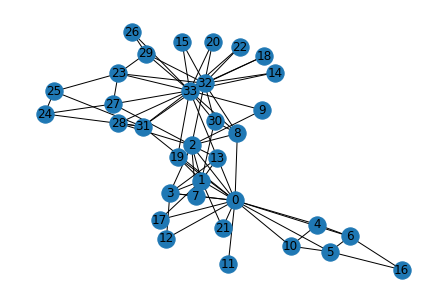

In [3]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Question 1: What is the average degree of the karate club network? (5 Points)

In [4]:
def average_degree(num_edges, num_nodes):
  # TODO: Implement this function that takes number of edges
  # and number of nodes, and returns the average node degree of 
  # the graph. Round the result to nearest integer (for example 
  # 3.3 will be rounded to 3 and 3.7 will be rounded to 4)

  avg_degree = 0

  ############# Your code here ############

  # 2E / N
  avg_degree = (2 * num_edges) / num_nodes
  avg_degree = round(avg_degree)
  
  #########################################

  return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: What is the average clustering coefficient of the karate club network? (5 Points)

In [5]:
def average_clustering_coefficient(G):
  # TODO: Implement this function that takes a nx.Graph
  # and returns the average clustering coefficient. Round 
  # the result to 2 decimal places (for example 3.333 will
  # be rounded to 3.33 and 3.7571 will be rounded to 3.76)

  avg_cluster_coef = 0

  ############# Your code here ############
  ## Note: 
  ## 1: Please use the appropriate NetworkX clustering function
  avg_cluster_coef = nx.average_clustering(G)
  avg_cluster_coef = round(avg_cluster_coef, 2)
  #########################################

  return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

Please complete the code block by implementing the PageRank equation: $r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$

In [6]:
def one_iter_pagerank(G, beta, r0, node_id):
  # TODO: Implement this function that takes a nx.Graph, beta, r0 and node id.
  # The return value r1 is one interation PageRank value for the input node.
  # Please round r1 to 2 decimal places.

  r1 = 0

  ############# Your code here ############
  ## Note: 
  ## 1: You should not use nx.pagerank

  # no directions so out degree is same as degree
#   r1 = (beta * r0/G.degree(node_id)) + ((1-beta)*(1/G.number_of_nodes()))
#   r1 = round(r1, 2)

  # actually, loop through all the neighbours; divide by their degrees
  # then add (1-beta)*num_nodes
  for neighbor in G.neighbors(node_id):
      r1 += beta * r0 / G.degree[neighbor]
  r1 += (1-beta) / G.number_of_nodes()
  r1 = round(r1, 2)
  # TODO After lecture 4

  #########################################

  return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


## Question 4: What is the (raw) closeness centrality for the karate club network node 5? (5 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [8]:
def closeness_centrality(G, node=5):
  # TODO: Implement the function that calculates closeness centrality 
  # for a node in karate club network. G is the input karate club 
  # network and node is the node id in the graph. Please round the 
  # closeness centrality result to 2 decimal places.

  closeness = 0

  ## Note:
  ## 1: You can use networkx closeness centrality function.
  ## 2: Notice that networkx closeness centrality returns the normalized 
  ## closeness directly, which is different from the raw (unnormalized) 
  ## one that we learned in the lecture.
  
  # network x normalised implementation
  #closeness = nx.closeness_centrality(G, u=node)

    # my implementation; may actually be correct..
  source_shortest_paths = nx.single_source_shortest_path_length(G, node)
  sum_source_shortest_paths = sum(source_shortest_paths.values())
  closeness = 1/sum_source_shortest_paths

#   # take closeness centrality in actuality
#   closeness = nx.closeness_centrality(G, u=node)
#   # and normalize it
#   closeness /= len(nx.node_connected_component(G, node))-1

  closeness = round(closeness, 2)
  #########################################

  return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.01


# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [9]:
import torch
print(torch.__version__)

1.11.0+cu113


## PyTorch tensor basics

We can generate PyTorch tensor with all zeros, ones or random values.

In [ ]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

PyTorch tensor contains elements for a single data type, the `dtype`.

In [ ]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

## Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor? (10 Points)

In [11]:
def graph_to_edge_list(G):
  # TODO: Implement the function that returns the edge list of
  # an nx.Graph. The returned edge_list should be a list of tuples
  # where each tuple is a tuple representing an edge connected 
  # by two nodes.

  edge_list = []

  ############# Your code here ############
  edge_list = [e for e in G.edges]
  #########################################

  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: Implement the function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2 x len(edge_list)].

  edge_index = torch.tensor([])

  ############# Your code here ############
  edge_index = torch.as_tensor(edge_list).T # transpose to get shape [2, len]
  #########################################

  return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Question 6: Please implement following function that samples negative edges. Then answer which edges (edge_1 to edge_5) can be potential negative edges in the karate club network? (10 Points)

In [14]:
import random

def sample_negative_edges(G, num_neg_samples):
  # TODO: Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. You do not
  # need to consider the corner case when the number of possible negative edges
  # is less than num_neg_samples. It should be ok as long as your implementation 
  # works on the karate club network. In this implementation, self loops should 
  # not be considered as either a positive or negative edge. Also, notice that 
  # the karate club network is an undirected graph, if (0, 1) is a positive 
  # edge, do you think (1, 0) can be a negative one?

  neg_edge_list = []

  ############# Your code here ############
  # my implementation; samples negative randomly
  # negative edges are sampled at random by selecting two nodes in graph, and checking
  # if they are connected or not. If not, then we have a negative sample, otherwise
  # it is discarded and the process repeats
#   list_g_nodes = list(G.nodes)
#   while len(neg_edge_list) < num_neg_samples:

#       # sample a and b randomly
#       random_node_a = random.choice(list_g_nodes)
#       random_node_b = random.choice(list_g_nodes)

#       # skip if these nodes are the same
#       if random_node_a == random_node_b:
#           continue

#       # if an edge between a and b; continue
#       if G.has_edge(random_node_a, random_node_b):
#           continue

#       # if reverse edge between b-a; continue
#       if (random_node_b, random_node_a) in neg_edge_list:
#           continue

#       neg_edge_list.append((random_node_a, random_node_b))

  # actually; we can use the positive edge list here too
  pos_edge_list = graph_to_edge_list(G)
  for node1 in G.nodes():
      for node2 in G.nodes():
          # only take if node1>=2; asserts a certain order
          if node1 >= node2:
              continue
          # skip positive edge nodes
          if (node1, node2) in pos_edge_list:
              continue
          neg_edge_list.append((node1, node2))
  # for all negative edges, sample
  neg_edge_list = random.sample(neg_edge_list, num_neg_samples)

  #########################################

  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge

# sample only our new edge list; note that we can also sample G, and if it is
# an edge; but my gut tells me that is not the case here..
for e in [edge_1, edge_2, edge_3, edge_4, edge_5]:
    e = (e[1], e[0]) if e[0]>e[1] else e
    if e in pos_edge_list:
        print(f'{e} is a positive edge')
    else:
        print(f'{e} is a negative edge')

# none of the above samples can be negative edges..

#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
(1, 7) is a positive edge
(1, 33) is a negative edge
(22, 33) is a positive edge
(0, 4) is a positive edge
(2, 4) is a negative edge


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.11.0+cu113


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [16]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [17]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-4.1937e-01, -1.2515e-02,  1.7609e+00, -5.6096e-01,  3.2427e-01,
          8.5370e-01,  1.9010e-01,  1.0535e-03]], grad_fn=<EmbeddingBackward0>)
tensor([[-4.1937e-01, -1.2515e-02,  1.7609e+00, -5.6096e-01,  3.2427e-01,
          8.5370e-01,  1.9010e-01,  1.0535e-03],
        [ 6.1345e-01, -1.4571e+00, -1.5523e-01, -7.4337e-01,  2.3223e-01,
          2.8056e+00, -5.7420e-01,  8.1464e-02]], grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [18]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: Implement this function that will create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. You do not need to change 
  # the values of num_node and embedding_dim. The weight matrix of returned 
  # layer should be initialized under uniform distribution. 

  emb = None

  ############# Your code here ############
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  random_tensor = torch.rand(num_node, embedding_dim)
  emb.weight.data = random_tensor

  #########################################

  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then we visualize each point, colored by the community it belongs to.

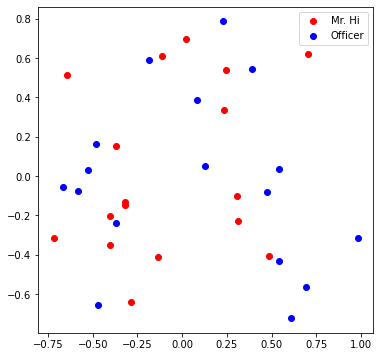

In [19]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: Training the embedding! What is the best performance you can get? Please report both the best loss and accuracy on Gradescope. (20 Points)

We want to optimize our embeddings for the task of classifying edges as positive or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likelihood of that edge being either positive (output of sigmoid > 0.5) or negative (output of sigmoid < 0.5).

Note that we're using the functions you wrote in the previous questions, _as well as the variables initialized in previous cells_. If you're running into issues, make sure your answers to questions 1-6 are correct.

In [25]:
from torch.optim import SGD
import torch.nn as nn

# MODEL NOT TRAINING: TODO: LOOK INTO AND LEARN
def accuracy(pred, label):
  # TODO: Implement the accuracy function. This function takes the 
  # pred tensor (the resulting tensor after sigmoid) and the label 
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will 
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places. 
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  accu = 0.0

  ############# Your code here ############
#   pred = torch.where(pred>0.5, 1, 0) # return 1 if > 0.5, else 0
#   accu = torch.sum(torch.eq(pred, label)) / (pred.shape[0])
  
  # implementation using torch sum and round
  accu = torch.sum(torch.round(pred)==label) / pred.shape[0]
  accu = torch.round(accu, decimals=4)

  #########################################

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: Train the embedding layer here. You can also change epochs and 
  # learning rate. In general, you need to implement: 
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch 
  # (6) Update the embeddings using the loss and optimizer 
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)
  print('*'*80)
  for i in range(epochs):

    ############# Your code here ############

    optimizer.zero_grad() # zero the optimizer
    node_emb = emb(train_edge) # 2,156, 16; # get node embeddings
    dot_product = torch.sum(node_emb[0] * node_emb[1], -1) # 156 # dot these
    result = sigmoid(dot_product) # 156 shape # sigmoid
    loss = loss_fn(result, train_label) # loss
    print(f'Epoch: {i}, Loss: {loss.item()}, Accuracy: {accuracy(result, train_label).item()}')
    loss.backward()
    optimizer.step()
    #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print('Pos Edge Index Shape:', pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )
print('Pos label shape:', pos_label.shape)

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
print('Train Label Shape:', train_label.shape)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print('train_edge shape:', train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

Pos Edge Index Shape: torch.Size([2, 78])
Pos label shape: torch.Size([78])
Train Label Shape: torch.Size([156])
train_edge shape: torch.Size([2, 156])
********************************************************************************
Epoch: 0, Loss: 2.089679002761841, Accuracy: 0.5
Epoch: 1, Loss: 2.075298547744751, Accuracy: 0.5
Epoch: 2, Loss: 2.048198699951172, Accuracy: 0.5
Epoch: 3, Loss: 2.010054588317871, Accuracy: 0.5
Epoch: 4, Loss: 1.9625204801559448, Accuracy: 0.5
Epoch: 5, Loss: 1.907199740409851, Accuracy: 0.5
Epoch: 6, Loss: 1.8456270694732666, Accuracy: 0.5
Epoch: 7, Loss: 1.7792483568191528, Accuracy: 0.5
Epoch: 8, Loss: 1.7094171047210693, Accuracy: 0.5
Epoch: 9, Loss: 1.6373811960220337, Accuracy: 0.5
Epoch: 10, Loss: 1.5642791986465454, Accuracy: 0.5
Epoch: 11, Loss: 1.4911363124847412, Accuracy: 0.5
Epoch: 12, Loss: 1.4188597202301025, Accuracy: 0.5
Epoch: 13, Loss: 1.3482369184494019, Accuracy: 0.5
Epoch: 14, Loss: 1.2799328565597534, Accuracy: 0.5
Epoch: 15, Loss: 

## Visualize the final node embeddings
Visualize your final embedding here! 
You can visually compare the figure with the previous embedding figure. 
After training, you should oberserve that the two classes are more evidently separated. 
This is a great sanitity check for your implementation as well.

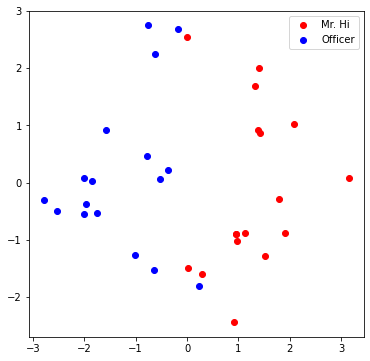

In [26]:
# Visualize the final learned embedding
visualize_emb(emb)

# Submission

In order to get credit, you must go submit your answers on Gradescope.